In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc


ROOT = Path('../')
sys.path.append(str(ROOT))

from src import CONSTANTS as C
from src import geneinfo as G
from src import preprocess as pp

In [2]:
SWNN_PATH = Path('E:/lxy_pro/003/stagewiseNN')
sys.path.append(str(SWNN_PATH))
import swnn

In [3]:
# EXT_SRC = Path('E:/lxy_pro/004/CAME')
# sys.path.append(str(EXT_SRC))
# from came import pp, pl

In [4]:
lineages = [
#     'Primordial germ cells',
    'Epithelial ectoderm',
    'Neural ectoderm',
    'Notochord',
    'Mesoderm',
#     'Unassigned',
    'Endoderm'
]


In [5]:
# dir_amph = Path('F:/003_amph/embryos')
dir_amph = Path('F:/003_amph/GA') #/ 'seplineage'

prefix = 'raw_ga_simple-'
prefix = 'normedGA-'
# lin = lineages[2]
lin = 'merged'

adt_lin0 = sc.read(dir_amph / f'{prefix}{lin}.h5ad')
sc.pp.filter_genes(adt_lin0, min_cells=0)
adt_lin0

AnnData object with n_obs × n_vars = 37832 × 14777
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'tech', 'peaks_snn_res.0.6', 'seurat_clusters', 'nCount_peaks_log10', 'nCount_RNA', 'nFeature_RNA', 'RNAcluster', 'RNAcluster_prob', 'lineage', 'batch', 'stage_name'
    var: 'n_cells'
    obsm: 'X_umap', 'X_umap_coembed'

In [6]:
'''merge B0 and B1'''
if 'B_3' in adt_lin0.obs['lineage'].unique():
    print('merge B_0 and B_1')
    tmp_dict = {'B_3': 'B_2', 'B_2': 'Primordial germ cells', 'B_1': 'B_0'}
    adt_lin0.obs['lineage'] = adt_lin0.obs['lineage'].astype(str).apply(
        lambda x: tmp_dict.get(x, x)
    )
adt_lin0.obs['lineage'].value_counts()

merge B_0 and B_1


Epithelial ectoderm      15990
Endoderm                  8516
Mesoderm                  5982
Neural ectoderm           3038
Notochord                 2248
B_0                       1363
Unassigned                 448
Primordial germ cells      244
B_2                          3
Name: lineage, dtype: int64

In [7]:
resdir = Path('E:/lxy_pro/003/amph/supp/20220209/lin_dynamics_swnn-GA') / (prefix + lin)
figdir = resdir / 'figs'
swnn.check_dirs(figdir)

sc.settings.figdir = figdir
sc.set_figure_params(fontsize=13)

a new directory made:
	E:\lxy_pro\003\amph\supp\20220209\lin_dynamics_swnn-GA\normedGA-merged\figs


### preprocessing

In [8]:
stage_order = C.StageNames#[1:]
stage_order_dct = dict(zip(stage_order, range(len(stage_order))))
print(stage_order_dct)

# key_group = 'RNAcluster' 
key_group = 'refined_group'
adt_lin0.obs[key_group] = adt_lin0.obs[['stage_name', 'RNAcluster']].apply(
    lambda x: '_'.join(map(str, x)), axis=1)

ordered_clusters = sorted(
    adt_lin0.obs[key_group].unique(),
    key=lambda x: stage_order_dct[x.split('_')[0]]
)
print(ordered_clusters)

'''re-order clusters and stages'''
adt_lin0.obs[key_group] = pd.Categorical(
    adt_lin0.obs[key_group].tolist(), 
    categories=ordered_clusters
)
adt_lin0.obs['stage_name'] = pd.Categorical(
    adt_lin0.obs['stage_name'].tolist(), categories=stage_order
)

{'B': 0, 'G3': 1, 'G4': 2, 'G5': 3, 'G6': 4, 'N0': 5, 'N1': 6, 'N3': 7, 'L0': 8}
['B_1', 'B_2', 'B_0', 'B_3', 'G3_1', 'G3_4', 'G3_3', 'G3_0', 'G3_2', 'G3_5', 'G6_7', 'G6_3', 'G6_2', 'G6_0', 'G6_8', 'G6_1', 'G6_4', 'G6_5', 'G6_6', 'G6_9', 'N1_0', 'N1_6', 'N1_5', 'N1_2', 'N1_1', 'N1_4', 'N1_7', 'N1_3', 'N1_8', 'N1_9', 'N3_8', 'N3_6', 'N3_0', 'N3_1', 'N3_13', 'N3_7', 'N3_12', 'N3_3', 'N3_11', 'N3_2', 'N3_10', 'N3_5', 'N3_9', 'N3_4', 'N3_14', 'L0_7', 'L0_1', 'L0_9', 'L0_8', 'L0_15', 'L0_10', 'L0_5', 'L0_2', 'L0_3', 'L0_4', 'L0_6', 'L0_0', 'L0_13', 'L0_12', 'L0_11', 'L0_16', 'L0_14']


In [9]:
adt_lin = swnn.normalize_default(adt_lin0, target_sum=None, copy=True)
# adt_lin = swnn.normalize_log_then_total(adt_lin0, target_sum=None, copy=True)

In [10]:
hvg_freq, hvg_dict = swnn.groupwise_hvgs_freq(adt_lin, groupby='stage_name')

In [11]:
hvgs = swnn.take_high_freq_elements(hvg_freq, 3)
print('Total of %d HVGs are used.' % len(hvgs))

Total of 2227 HVGs are used.


In [12]:
adt_lin = swnn.set_adata_hvgs(adt_lin, gene_list=hvgs)

In [13]:
stage_key = 'stage_name'
swnn.wrapper_scale(adt_lin, groupby=stage_key)

AnnData object with n_obs × n_vars = 37832 × 2227
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'tech', 'peaks_snn_res.0.6', 'seurat_clusters', 'nCount_peaks_log10', 'nCount_RNA', 'nFeature_RNA', 'RNAcluster', 'RNAcluster_prob', 'lineage', 'batch', 'stage_name', 'refined_group'
    var: 'n_cells', 'highly_variable'
    uns: 'log1p'
    obsm: 'X_umap', 'X_umap_coembed'

In [14]:
# just check
adt_lin, adt_lin.X[:2, :]

(AnnData object with n_obs × n_vars = 37832 × 2227
     obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'tech', 'peaks_snn_res.0.6', 'seurat_clusters', 'nCount_peaks_log10', 'nCount_RNA', 'nFeature_RNA', 'RNAcluster', 'RNAcluster_prob', 'lineage', 'batch', 'stage_name', 'refined_group'
     var: 'n_cells', 'highly_variable'
     uns: 'log1p'
     obsm: 'X_umap', 'X_umap_coembed',
 array([[ 0.        ,  0.        ,  1.29105244, ..., -0.84153777,
          0.        ,  0.        ],
        [ 0.        ,  0.        , -0.94641554, ...,  1.17330798,
          0.        ,  0.        ]]))

### Inputs & parameters

In [15]:
# ====== Inputs ======
data_matrix = adt_lin.X
stage_order = ("B", "G3", "G6", "N1", "N3", "L0")
# stage_order = ("G3", "G4", "G5", "G6", "N0", "N1", "N3", "L0")

stage_labels = adt_lin.obs['stage_name']

# only used for building tree, each group will be taken as a tree node
group_labels = adt_lin.obs['refined_group']
# group_labels.value_counts()


In [16]:
# ====== Parameters ======
ks = [30] + [20] * 3 + [10] * 2 # specified for different stages
n_pcs = 50     # you can also set it a list like ``ks``
leaf_size = 1  # 1 for exact KNN

### Main

In [17]:
builder = swnn.Builder(stage_order=stage_order)

In [18]:
distmat, connect = builder.build_graph(
        X=data_matrix, stage_lbs=stage_labels,
        ks=ks, n_pcs=n_pcs,
        leaf_size=leaf_size,
    )

perform KNN searching: B in B
perform KNN searching: G3 in B
perform KNN searching: G6 in G3
perform KNN searching: N1 in G6
perform KNN searching: N3 in N1
perform KNN searching: L0 in N3


In [19]:
swnn.set_precomputed_neighbors(adt_lin, distmat, connect)
sc.tl.umap(adt_lin, min_dist=0.1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


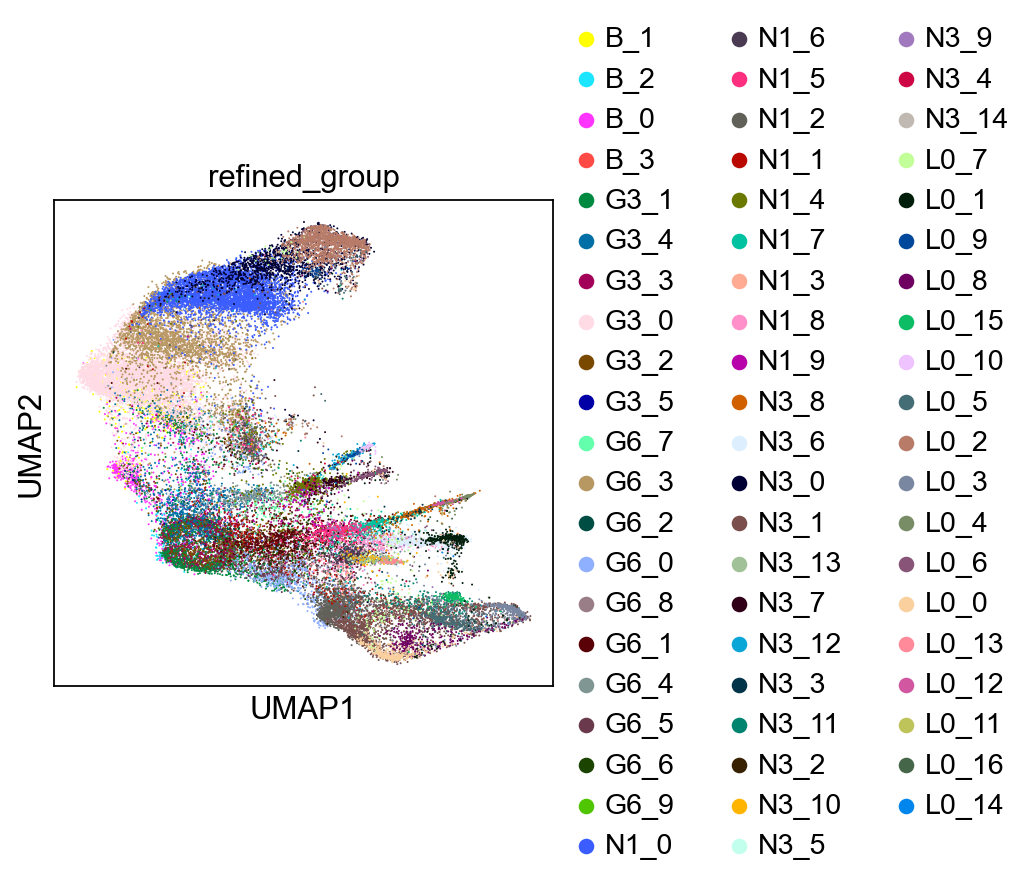

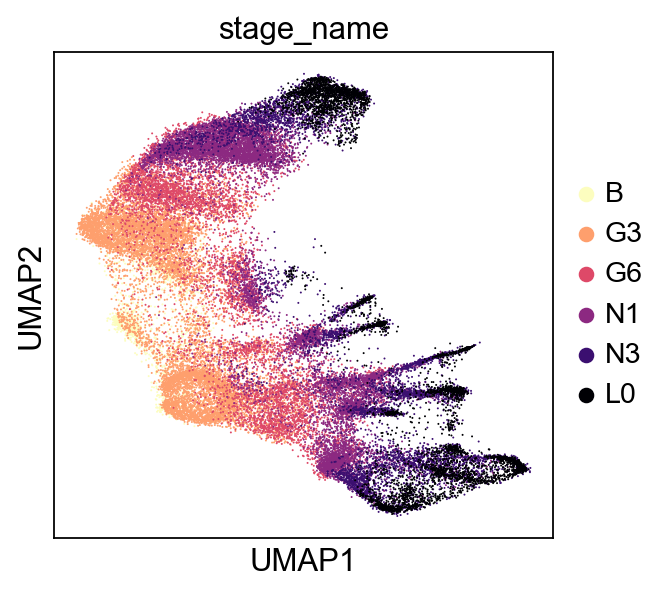

In [32]:
sc.set_figure_params(fontsize=14)

sc.pl.umap(adt_lin, color='refined_group', save=f'-{lin}_group.pdf')
sc.pl.umap(adt_lin, color='stage_name', 
           palette='magma_r',  #'plasma_r', 
           save=f'-{lin}_stage.pdf')

In [21]:
def decide_colors(adt, key, color_dict, categories=None):
    adt.obs[key] = pd.Categorical(adt.obs[key], categories=categories)
    categories = adt.obs[key].cat.categories
    adt.uns[f'{key}_colors'] = [color_dict[c] for c in categories]

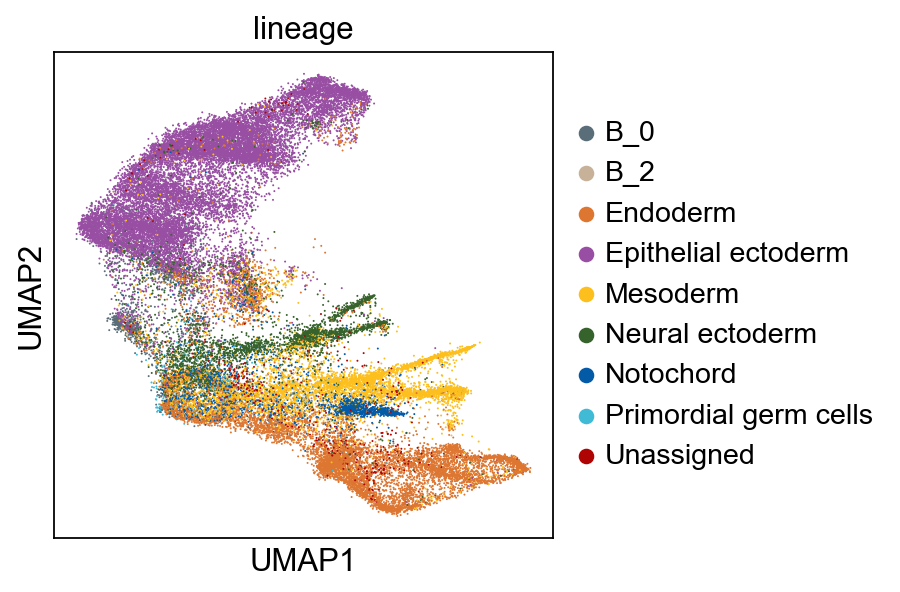

In [22]:
decide_colors(adt_lin, 'lineage', C.LineageColorMap)
sc.pl.umap(adt_lin, color='lineage', save=f'-{lin}_lineage.pdf')


In [23]:
C.LineageColorMap

{'B_0': '#596e79',
 'B_1': '#b3b3b3',
 'B_2': '#c7b198',
 'B_3': '#40bad5',
 'Primordial germ cells': '#40bad5',
 'Epithelial ectoderm': '#984ea3',
 'Neural ectoderm': '#36622b',
 'Notochord': '#035aa6',
 'Mesoderm': '#fcbf1e',
 'Unassigned': '#af0404',
 'Endoderm': '#dd7631'}

### DPT-pseudotime

In [24]:
def group_center(adata, group, groupby='leiden'):
    ''' 
    find the center of a group, return the index
    temperally take the node with max degree.
    '''
    #    indices_ = ph.adata.obs[groupby]  == group
    indices = np.flatnonzero(adata.obs[groupby] == group)
    A = adata.uns['neighbors']['connectivities'][indices, :]

    # compute the degrees
    d = A.sum(axis=1).A1
    center_id = indices[np.argmax(d)]
    print(f'Auto-selected node {center_id}, with max degree {d.max()}')
    return center_id

In [25]:
# analysis
n_dcs = 20
sc.tl.diffmap(adt_lin, n_comps=n_dcs)
# adt_lin.uns['iroot'] = group_center(adt_lin, 'B_0', groupby='lineage')
adt_lin.uns['iroot'] = group_center(adt_lin, 'B_0', groupby='refined_group')

sc.tl.dpt(adt_lin, n_dcs=n_dcs,)

Auto-selected node 1311, with max degree 1910.0


<ipython-input-24-9924cc507272>:8: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  A = adata.uns['neighbors']['connectivities'][indices, :]


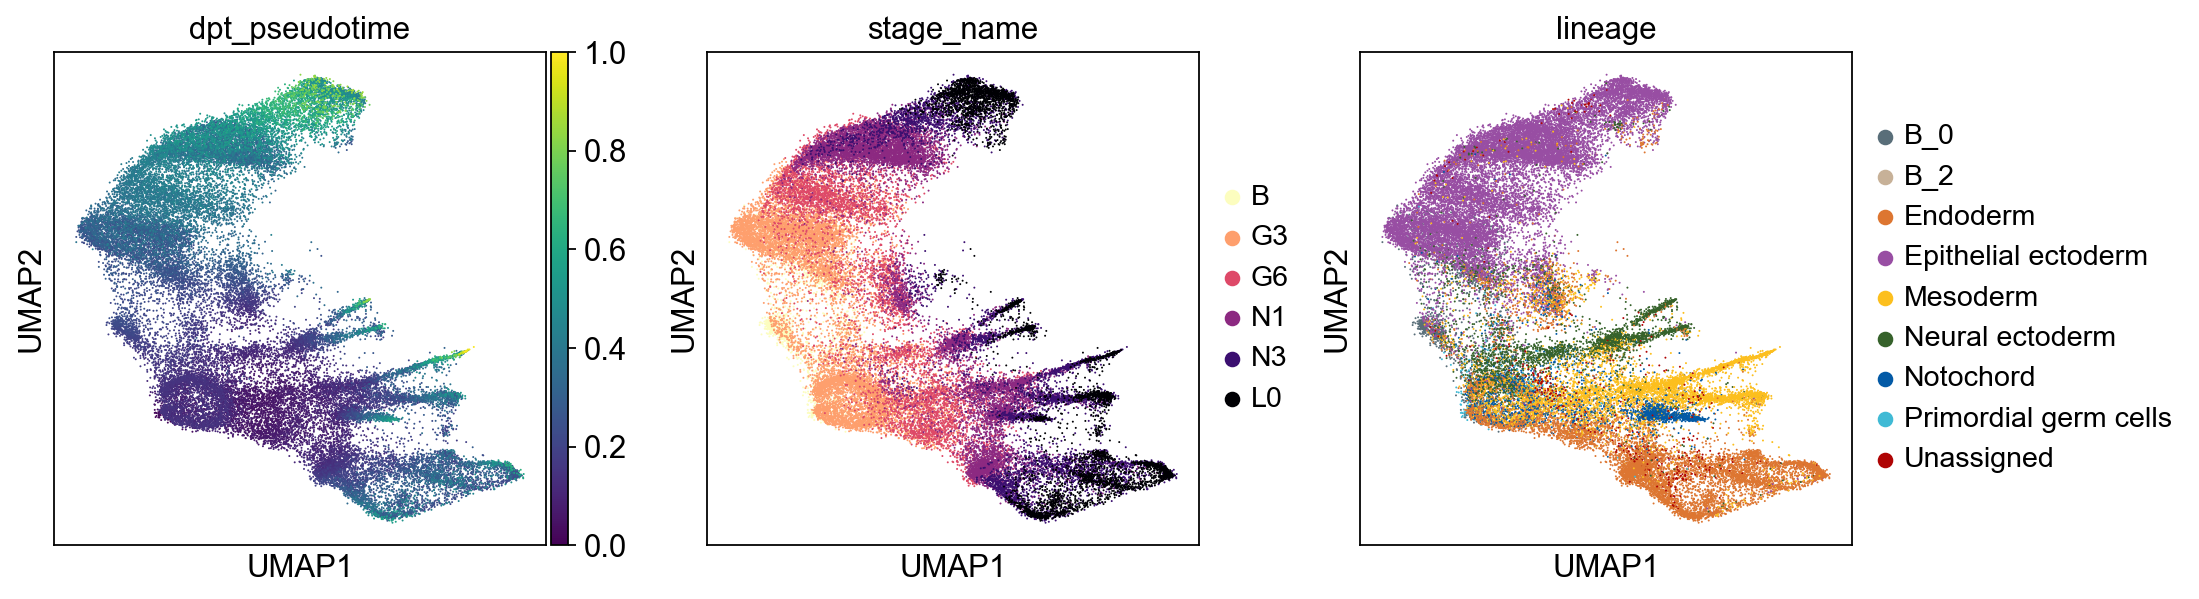

In [33]:
sc.pl.umap(adt_lin, color='dpt_pseudotime', title='pseudotime', save=f'-{lin}-pseudotime', show=False)
sc.pl.umap(adt_lin, color=['dpt_pseudotime', 'stage_name', 'lineage'], save=f'-{lin}-pseudotime_vs_stage')

### Save 'dpt_pseudotime'

In [34]:
meta = adt_lin.obs.copy()
meta['UMAP1'] = adt_lin.obsm['X_umap'][:, 0]
meta['UMAP2'] = adt_lin.obsm['X_umap'][:, 1]

meta.to_csv(dir_amph / f'metadata-{lin}.csv')
meta

,orig.ident,nCount_peaks,nFeature_peaks,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,nFeature_RNA,RNAcluster,RNAcluster_prob,lineage,batch,stage_name,refined_group,dpt_pseudotime,UMAP1,UMAP2
index,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAACCCGA-1-0,ATAC,3669,1608,93691,25397,683,15718,23042,0,28851,...,1255,1,0.894737,B_0,0,B,B_1,0.254244,-13.425716,-28.866283
AAACGAAAGACGCCCT-1-0,ATAC,3309,1324,125416,45884,856,20904,32797,0,24975,...,1086,2,0.789474,Primordial germ cells,0,B,B_2,0.079513,-12.714746,-31.580009
AAACGAAAGGTTTCTG-1-0,ATAC,1911,902,42140,11123,272,7210,11042,0,12493,...,840,1,1.000000,B_0,0,B,B_1,0.277067,-13.875581,-29.059465
AAACGAAGTCTGAGCC-1-0,ATAC,3480,1453,89539,25108,592,14183,22759,0,26897,...,1209,2,0.684211,Primordial germ cells,0,B,B_2,0.018194,-13.084942,-32.723503
AAACGAATCGCAGATT-1-0,ATAC,5240,1714,94631,32036,646,16019,24886,0,21044,...,1321,0,1.000000,B_0,0,B,B_0,0.144249,-13.112216,-31.258286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTGTTCATTGCCC-1-5,ATAC,32174,8068,100283,48042,838,14500,15153,0,21750,...,5877,0,0.947368,Endoderm,5,L0,L0_0,0.272160,-9.500033,-35.534836
TTTGTGTTCCCAATGA-1-5,ATAC,10803,4149,20121,6666,162,2849,3054,0,7390,...,3453,6,1.000000,Neural ectoderm,5,L0,L0_6,0.264374,-9.169866,-31.839083
TTTGTGTTCGATGTGT-1-5,ATAC,17795,5888,53264,21598,365,12462,7576,0,11263,...,4620,2,1.000000,Epithelial ectoderm,5,L0,L0_2,0.441377,-10.270942,-23.856113


In [35]:
# prefix = 'raw_ga_simple-'
adt_lin00 = sc.read(dir_amph / f'{prefix}{lin}.h5ad')
for c in meta.columns:
    if c not in adt_lin00.obs.columns:
        adt_lin00.obs[c] = meta[c]
        print(f'add column [{c}]')

In [36]:
fp00 = dir_amph / f'{prefix}{lin}.h5ad'
print(fp00)
adt_lin00.write(fp00)

F:\003_amph\GA\normedGA-merged.h5ad


## baseline

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
... storing 'lineage' as categorical


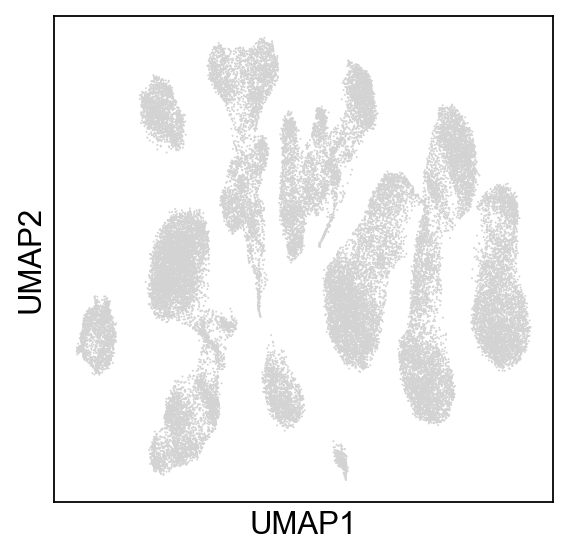

In [30]:
adt_lin01 = pp.quick_pre_vis(adt_lin0, batch_key=None)

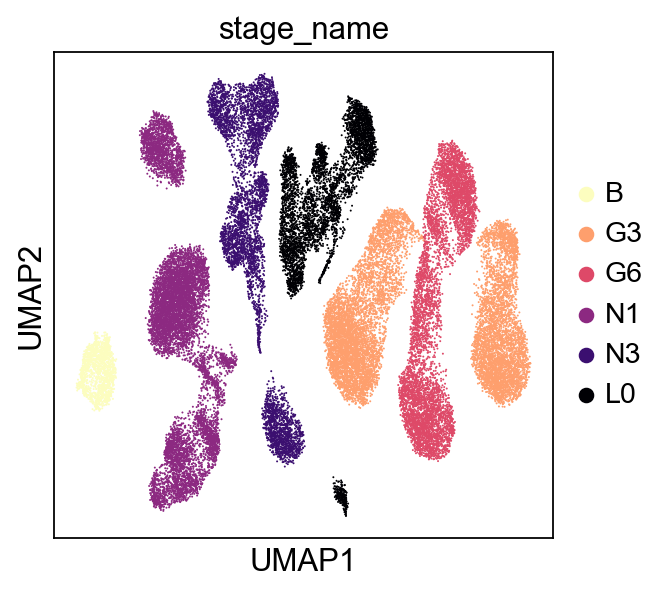

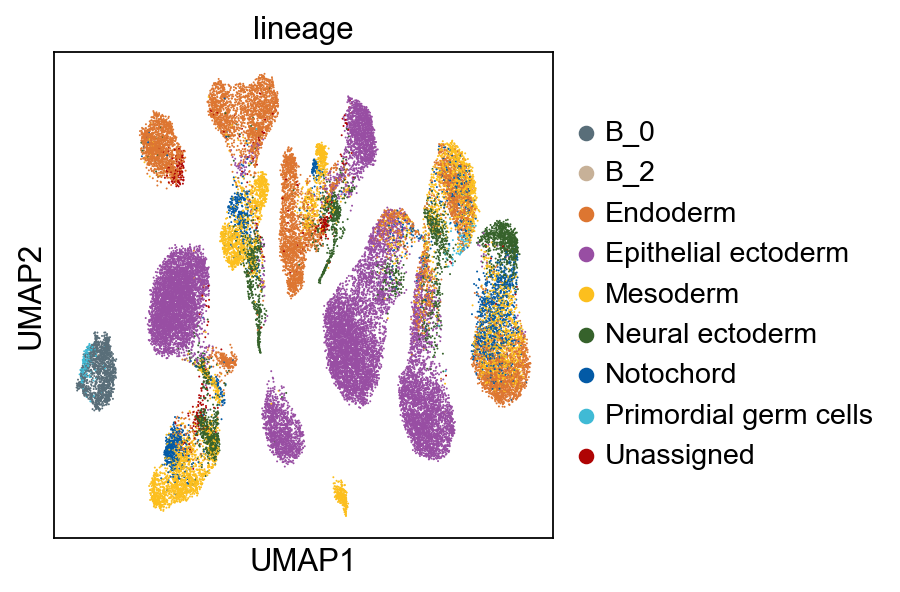

In [37]:
decide_colors(adt_lin01, 'lineage', C.LineageColorMap)
sc.pl.umap(adt_lin01, color=['stage_name'], palette='magma_r', save=f'-{lin}-baseline')
sc.pl.umap(adt_lin01, color=['lineage'], save=f'-{lin}-lin-baseline')